# Studying mobility changes due to covid 19 political measures

#### simple PCA analysis

input:
- df_param as Google_mobility_fit_df_param.csv
- df_param as Google_mobility_raw_df.csv

no output

In [1]:
# Data Manipulation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyodbc as pyo
import time
from datetime import datetime
from dateutil.parser import  *
import itertools

# Data Visualization
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True) 
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# PCA
from sklearn import decomposition

## Import data & rapid preprocessing

In [2]:
# Import per country, per sector time series (% mobility change wrt. baseline)
url = "https://raw.githubusercontent.com/sylvainhislaire/projects/master/Google_Mobility_raw_df.csv"
df = pd.read_csv(url, header = [0,1], index_col = [0])

# Import per country, per sector bset-fit sigmoid parameters (acuteness = 1/transition length)
url = "https://raw.githubusercontent.com/sylvainhislaire/projects/master/Google_Mobility_fit_df_param.csv"
df_param = pd.read_csv(url, header = [0,1], index_col = [0])

# retrieve sector and country names
sectors = list(df_param.groupby('Sector',axis=1).min().columns.get_level_values('Sector'))
countries = list(df_param.groupby('Country',axis=1).min().columns.get_level_values('Country'))

# visualisation
df_param

Country               Afghanistan                                             \
Sector         Grocery & pharmacy      Parks Residential Retail & recreation   
parameters                                                                     
acuteness               10.000000   0.624789    0.284801            0.319800   
transition day          41.857616  40.362680   41.173570           39.386526   
intensity              -29.895426 -14.646242  -12.959441          -46.476161   
offset                   4.095363   2.463956   -0.674879            0.798643   
error                   32.298828   5.601513    3.371539           18.888179   

Country                                                Angola             \
Sector         Transit stations  Workplace Grocery & pharmacy      Parks   
parameters                                                                 
acuteness              0.209542   3.089872          10.000000   0.323832   
transition day        38.719832  41.621038          40.946044  37.074623   
intensity            -52.000000 -35.980899         -37.516984 -45.320953   
offset                 4.622126   1.085921           1.707271   4.925963   
error                 22.668155  90.130409          52.949917  42.287646   

Country                                         ...      Zambia  \
Sector         Residential Retail & recreation  ... Residential   
parameters                                      ...               
acuteness         0.420756            3.043538  ...    0.245632   
transition day   37.654515           40.501179  ...   41.888258   
intensity       -27.296113          -51.716102  ...  -11.148057   
offset           -0.171635           -3.703236  ...   -2.364054   
error            15.765583           77.804041  ...    5.859250   

Country                                                          \
Sector         Retail & recreation Transit stations   Workplace   
parameters                                                        
acuteness                 0.200000         0.200000    0.200000   
transition day           41.499351        41.417020   44.821920   
intensity               -22.289023       -21.916520  -27.602718   
offset                    0.170077        -3.577105    4.490555   
error                    35.274266        18.709830  123.015129   

Country                  Zimbabwe                                             \
Sector         Grocery & pharmacy      Parks Residential Retail & recreation   
parameters                                                                     
acuteness               10.000000   0.468455    0.498078           10.000000   
transition day          43.519254  42.017633   41.400674           43.415239   
intensity              -60.424010 -46.444337  -40.921894          -63.639418   
offset                   5.093659  -3.868086   -1.326554           -2.683319   
error                   33.668760  35.943083   21.148464           41.060552   

Country                                      
Sector         Transit stations   Workplace  
parameters                                   
acuteness             10.000000    0.599979  
transition day        43.584050   42.457331  
intensity            -65.611296  -68.743481  
offset               -13.860382    4.346077  
error                 43.221788  193.039495  

[5 rows x 775 columns]

In [3]:
# find and delete countries with less than 6 sectors
to_be_deleted = []
for country in countries:
    if len(df_param[country].columns) < 6:
        print(country + ' ' + str(len(df[country].columns)))
        to_be_deleted.append(country)
        
df_param_clean = df_param.drop(to_be_deleted,axis=1)

# find and delete countries with NaN values
to_be_deleted = []
for column in df_param_clean:
    for i in df_param_clean[column]:
        if i != i:
            print(column)
            to_be_deleted.append(column[0])  
            
# clean dataset
df_param_clean = df_param_clean.drop(to_be_deleted,axis=1)

Guinea-Bissau 4
Liechtenstein 4
Réunion 5


In [4]:
# set the features (sectors and sigmoid parameters) as columns, countries as rows
X = df_param_clean.transpose().reset_index('Sector').pivot(columns='Sector')

# normalising
X = (X-X.mean()) / X.std() # unbiased std estimator ./(N-1)

## PCA

number of componants: 8
explained variance per component: [0.22310365 0.15943661 0.10239884 0.0815621  0.06545651 0.04490163
 0.04286793 0.03866482]
total explained variance: 0.7583921018274336


Text(0.5, 1.0, 'Cumulative proportion of variance explained')

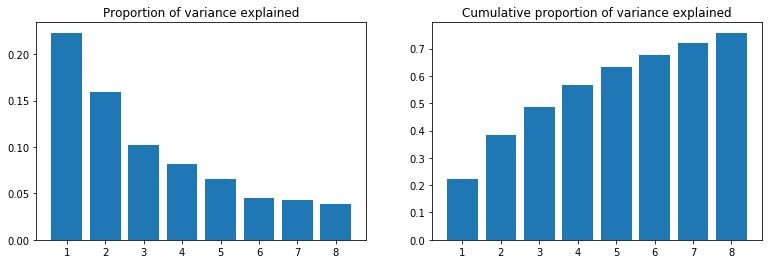

In [5]:
# Apply PCA
pca = decomposition.PCA(n_components=0.75)
pca.fit(X)
Xpca = pca.transform(X)
print('number of componants: ' + str(pca.n_components_))
print('explained variance per component: ' + str(pca.explained_variance_ratio_))
print('total explained variance: ' + str(sum(pca.explained_variance_ratio_)))

# visualisation: %variance per Principal Component
plt.figure(figsize = (13,4))
plt.subplot(1,2, 1)
plt.bar(range(1,pca.n_components_+1),pca.explained_variance_ratio_)
plt.title('Proportion of variance explained')

# visualisation: cumulative % variance per Principal Component
plt.subplot(1,2, 2)
data = []
for i in range(1,pca.n_components_+1):
    data.append(sum(pca.explained_variance_ratio_[0:i]))
plt.bar(range(1,pca.n_components_+1),data)
plt.title('Cumulative proportion of variance explained')

In [6]:
# 3D plot with PC1, PC2, PC3 as axis and PC4 as color
df_pc = pd.DataFrame(Xpca, columns = ['1st','2nd','3rd','4th','5th','6th','7th','8th'])
fig = px.scatter_3d(df_pc, x='1st', y='2nd', z='3rd',
              color='4th')
fig.show()

In [7]:
# retrieve feature names
titles = []
for i in range(len(X.columns)):
    title = ''
    for j in [0,1]:
        title += list(X.columns)[i][j]
        if j ==0:
            title+= ', '
    titles.append(title)

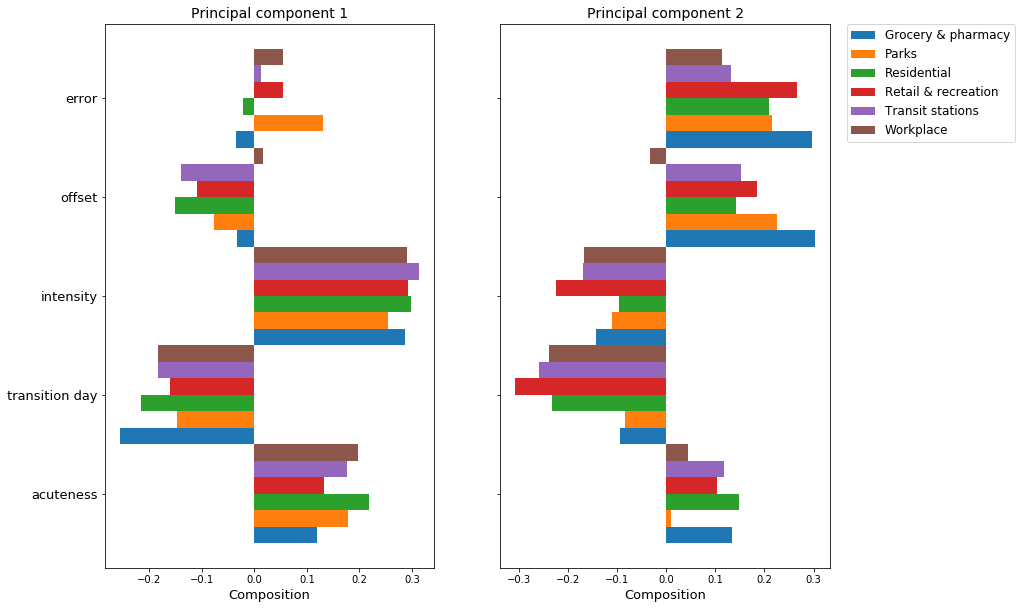

In [8]:
# Composition of PC1 and PC2, grouped by sigmoid parameters
labels = list(df_param.index)

fig, ax = plt.subplots(1, 2,figsize = (13,10),sharey = True)

x = np.arange(len(labels))  # the label locations
width = 1/6  # the width of the bars  

for j in [0,1]:
    
    pc_compo = []
    for i in range(len(sectors)):
        pc_compo.append((pca.components_[j])[np.array(range(i,pca.n_features_,len(sectors)))[:]])
        ax[j].barh(x - 2*width-width/2+i/6, pc_compo[i], width, label=sectors[i])
  
    ax[j].set_xlabel('Composition',size=13)
    ax[j].set_title('Principal component ' + str(j+1),size=14)
    ax[j].set_yticks(x)
    ax[j].set_yticklabels(labels,size=13)

    if j == 1:
        ax[j].legend(fontsize = 12,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

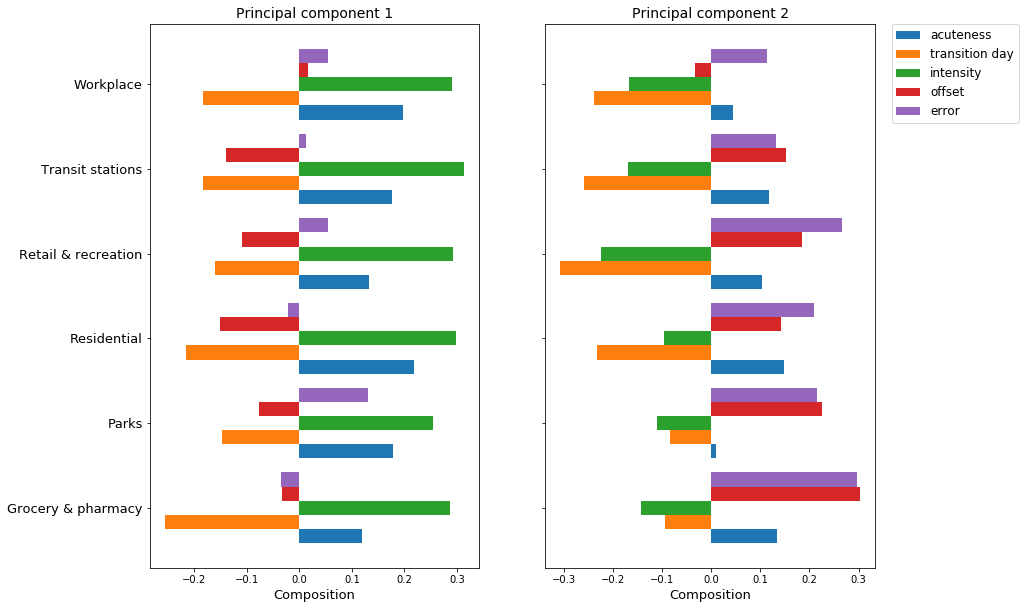

In [9]:
# Composition of PC1 and PC2, grouped by sector
labels = sectors

fig, ax = plt.subplots(1, 2,figsize = (13,10),sharey = True)

x = np.arange(len(labels))  # the label locations
width = 1/6  # the width of the bars  

for j in [0,1]:
    
    pc_compo = []
    for i in range(len(list(df_param.index))):
        pc_compo.append((pca.components_[j])[np.array(range(0,len(sectors)))[:]+len(sectors)*i])
        ax[j].barh(x - 2*width+i/6, pc_compo[i], width, label=df_param.index[i])
  
    ax[j].set_xlabel('Composition',size=13)
    ax[j].set_title('Principal component ' + str(j+1),size=14)
    ax[j].set_yticks(x)
    ax[j].set_yticklabels(labels,size=13)

    if j == 1:
        ax[j].legend(fontsize = 12,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### Now, we know that the transition length = 1/acuteness might be interesting too
pca with limited number of features (& 6 sectors): 'transition length','transition day','intensity'

In [10]:
X = X.join(X.loc[:,('acuteness',sectors)],rsuffix = ' inverse')
X = X.rename(columns = {'acuteness inverse' : 'transition length'})
X.xs('transition length', axis = 1, level=0).std() # taking 1/acuteness instead of acuteness does not change the result of the PCA

Sector
Grocery & pharmacy     1.0
Parks                  1.0
Residential            1.0
Retail & recreation    1.0
Transit stations       1.0
Workplace              1.0
dtype: float64

number of componants: 5
explained variance per component: [0.34828473 0.19041027 0.11936155 0.0812037  0.0487145 ]
total explained variance: 0.7879747528268047


Text(0.5, 1.0, 'Cumulative proportion of variance explained')

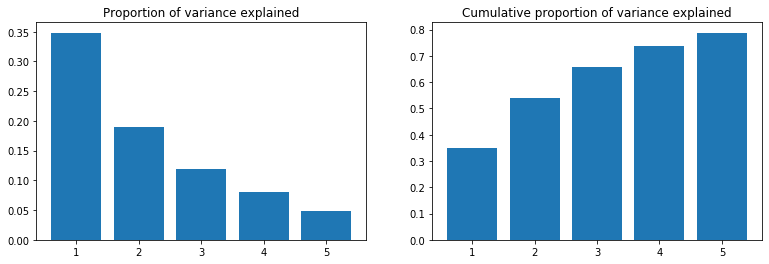

In [11]:
# Apply PCA
pca = decomposition.PCA(n_components=0.75)
pca.fit(X[['transition length','transition day','intensity']])
Xpca = pca.transform(X[['transition length','transition day','intensity']])
print('number of componants: ' + str(pca.n_components_))
print('explained variance per component: ' + str(pca.explained_variance_ratio_))
print('total explained variance: ' + str(sum(pca.explained_variance_ratio_)))

# visualisation: cumulative % variance per Principal Component
plt.figure(figsize = (13,4))
plt.subplot(1,2, 1)
plt.bar(range(1,pca.n_components_+1),pca.explained_variance_ratio_)
plt.title('Proportion of variance explained')

# visualisation: % variance per Principal Component
plt.subplot(1,2, 2)
data = []
for i in range(1,pca.n_components_+1):
    data.append(sum(pca.explained_variance_ratio_[0:i]))
plt.bar(range(1,pca.n_components_+1),data)
plt.title('Cumulative proportion of variance explained')

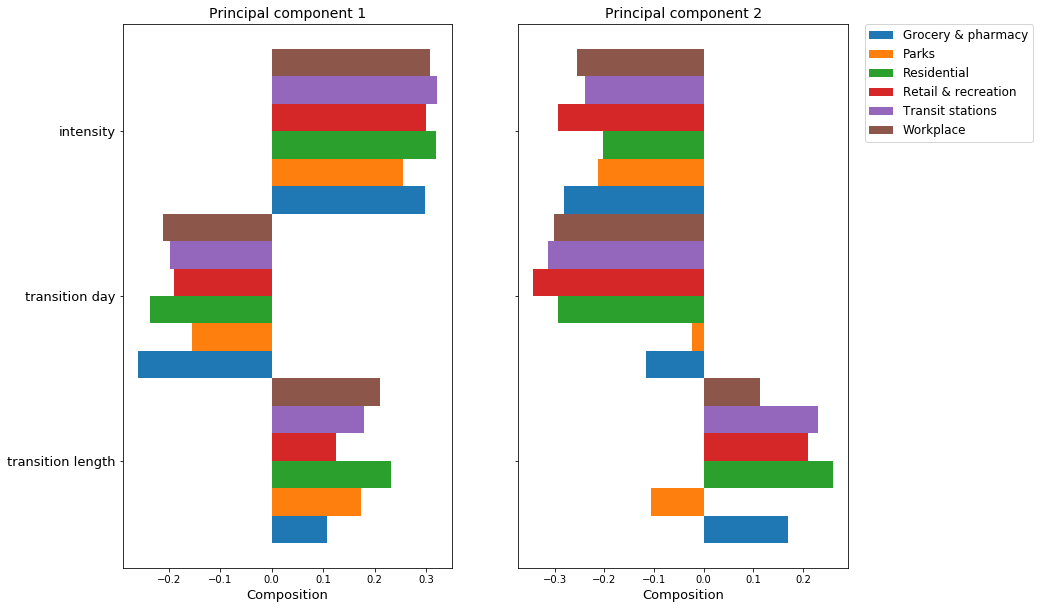

In [12]:
# Composition of PC1 and PC2, grouped by sigmoid parameter
labels = ['transition length','transition day','intensity']

fig, ax = plt.subplots(1, 2,figsize = (13,10),sharey = True)

x = np.arange(len(labels))  # the label locations
width = 1/6  # the width of the bars  

for j in [0,1]:
    
    pc_compo = []
    for i in range(len(sectors)):
        pc_compo.append((pca.components_[j])[np.array(range(i,pca.n_features_,len(sectors)))[:]])
        ax[j].barh(x - 2*width-width/2+i/6, pc_compo[i], width, label=sectors[i])
  
    ax[j].set_xlabel('Composition',size=13)
    ax[j].set_title('Principal component ' + str(j+1),size=14)
    ax[j].set_yticks(x)
    ax[j].set_yticklabels(labels,size=13)

    if j == 1:
        ax[j].legend(fontsize = 12,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)